# TetA fitness model explorator

(c) 2021 Manuel Razo & Tom Röschinger. This work is licensed under a 
[Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). 
All code contained herein is licensed under an 
[MIT license](https://opensource.org/licenses/MIT).

In [1]:
import os
import git

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd
import itertools

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX
# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D
import bokeh.palettes

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

# Import project library
import fit_seq

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
# Set PBoC plotting format
fit_seq.viz.pboc_style_mpl()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

# TetA resistance

Our experiments include the expression of a tetracycline-specific efflux pump *tetA*. The presence of this efflux pump and its non-linear Michaelis-Menten-like behavior changes the intracellular drug concentration. The resulting equations for the steady-state intracellular antibiotic concentration gives a quadratic equation of the form
$$
0=a^{2}\left[-\lambda-j\right]
+ a\left[-K_{m} \lambda + j a_{ex}-j K_{m}-\frac{\lambda}{\lambda_{0}} V_{0}\right]
+ j a_{ex} K_m,
$$
with 
- $a$: Intracellular drug concentration
- $\lambda$: Growth rate
- $j$: Membrane diffusion parameter
- $K_M$: Michaelis-Menten constant for efflux pump
- $a_{ex}$: Extracellular drug concentration
- $V_0$: Scale of pumping power (related to expression of resistance gene).


The roots of this quadratic equation are then plugged into the resulting equation that determines the growth rate
$$
0=\lambda \left( \frac{a}{\kappa_t K_d} + \frac{\Delta r}{\lambda_0} \right) + r_\mathrm{min}\left(1+\frac{a}{K_d}\right) - r_\mathrm{max},
$$
where $r_\mathrm{min}$ is the minimal ribosomal fraction of the proteome necessary for growth, $r_\mathrm{max}$ the maximal possible ribosome fraction, and $\Delta r = r_\mathrm{max} - r_\mathrm{min}$ is their difference.

Let us define these two equations in `sympy`. For this, we first define all of the variables.

We now solve the second equation for the drug concentration

Let's now define a function that finds the roots of this 4th degree polynomial.

In [3]:
def tetA_lam_roots(aex, lam_o, kt, Kd, Km, j, Vo, del_r, rmin):
    """
    Function to numerically compute the roots of the 4th degree
    polynomial that defines the growth rate for the tetA system

    Parameters
    ----------
    aex : float.
        Extracellular antibiotic concentration
    lam_o : float.
        Growth rate in the absence of drug.
    kappa_t : float.
        Nutritional capacity.
    Kd : float.
        Drug-ribosome dissociation constant.
    Km : float.
        Drug-pump Michaelis-Menten constant.
    j : float.
        Membrane permeability to the drug.
    Vo : float.
        Expression of efflux pump under no antibiotic conditions.
    del_r : float.
        Dynamic range for the fraction of proteome made by ribosomes.
    """
    # Initialize array to save roots
    # NOTE: Needs to allow for complex number entries
    roots = np.zeros([len(aex), 4], dtype=complex)
    # Loop through aex values
    for i, ae in enumerate(aex):
        # Define elements of polynomial of the form
        # A + Bx + Cx**2 + Dx**3 + Ex**4 = 0
        A = -(Kd ** 2) * kappa_t ** 2 * j * del_r ** 2
        B = (
            -(Kd ** 2) * kappa_t ** 2 * del_r ** 2
            + 2 * Kd ** 2 * kappa_t ** 2 * j * del_r ** 2 / lam_o
            - Kd * Km * kappa_t * j * del_r
            + Kd * kappa_t * ae * j * del_r
        )
        C = (
            2 * Kd ** 2 * kappa_t ** 2 * del_r ** 2 / lam_o
            - Kd ** 2 * kappa_t ** 2 * j * del_r ** 2 / lam_o ** 2
            - Kd * Km * kappa_t * del_r
            + Kd * Km * kappa_t * j * del_r / lam_o
            - Kd * Vo * kappa_t * del_r / lam_o
            + Kd * kappa_t * del_r ** 2
            - Kd * kappa_t * ae * j * del_r / lam_o
            + Km * ae * j
        )
        D = (
            -(Kd ** 2) * kappa_t ** 2 * del_r ** 2 / lam_o ** 2
            + Kd * Km * kappa_t * del_r / lam_o
            + Kd * Vo * kappa_t * del_r / lam_o ** 2
            - 2 * Kd * kappa_t * del_r ** 2 / lam_o
            + Km * del_r
        )
        E = Kd * kappa_t * del_r ** 2 / lam_o ** 2 - Km * del_r / lam_o

        # Compute root
        roots[i, :] = np.polynomial.Polynomial([A, B, C, D, E]).roots()

    return roots

Let's make sure that the function works WHY DOES J NEED TO BE AT LEAST 10 HERE?

In [4]:
# Define parameters
aex = [0.0]  # µM
lam_o = 0.68  # h**-1
kappa_t = 0.06  # µM**-1 h**-1
Kd = .1  # µM
Km = 10  # µM
rmin = 19.3
j = 100
# h**-1
Vo = 0
del_r = 46.5  # µM

# Pack parameters together
args = (aex, lam_o, kappa_t, Kd, Km, j, Vo, del_r, rmin)
# Find roots
tetA_lam_roots(*args)

array([[-0.77160248+0.j, -0.0290937 +0.j,  0.68      +0.j,
         0.77760248+0.j]])

Let's now take a look at the roots with an interactive plot.

In [5]:
def _tetA_lam_roots_plot(lam_slider, j_slider, Vo_slider, aex_slider, norm_button, ax, color):
    """
    Function to generate interactive widget
    """
    # Define range of concentrations
    aex = np.linspace(0, aex_slider, 1000)

    # Pack parameters together
    args = (
        aex,
        lam_slider,
        kappa_t,
        Kd,
        Km,
        j_slider,
        Vo_slider * j_slider,
        del_r,
        rmin
    )

    # Define colors
    col = bokeh.palettes.Blues4
    
    # Check of they should be normalized
    if norm_button == "normalized":
        # Compute roots
        roots = tetA_lam_roots(*args).T / lam_slider
        
        # Define y-axis label
        y_axis_label = "normalized growth rate (λ/λ₀)"
        # Initialize Bokeh figure

        # Add points
        for i, r in enumerate(roots):
            ax.plot(
                aex[
                    (np.isclose(r.imag, 0))
                    & (r.real <= 1)
                    & (r.real >= 0)
                ].real,
                r[
                    (np.isclose(r.imag, 0))
                    & (r.real <= 1)
                    & (r.real >= 0)
                ].real,
                color=color,
                lw=2
            )
    else:
        # Compute roots
        roots = tetA_lam_roots(*args).T
        # Define y-axis label
        y_axis_label = "growth rate (h⁻¹)"
        # Initialize Bokeh figure
        # Add points
        for i, r in enumerate(roots):
            ax.plot(
                aex[
                    (np.isclose(r.imag, 0))
                    & (r.real <= lam_slider)
                    & (r.real >= 0)
                ].real,
                r[
                    (np.isclose(r.imag, 0))
                    & (r.real <= lam_slider)
                    & (r.real >= 0)
                ].real,
                color=color,
                lw=2
            )
        # Set y axis limits
    return ax

[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]


<ipython-input-11-f2209b43b50d>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-11-f2209b43b50d>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-11-f2209b43b50d>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-11-f2209b43b50d>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(
<ipython-input-11-f2209b43b50d>:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyw

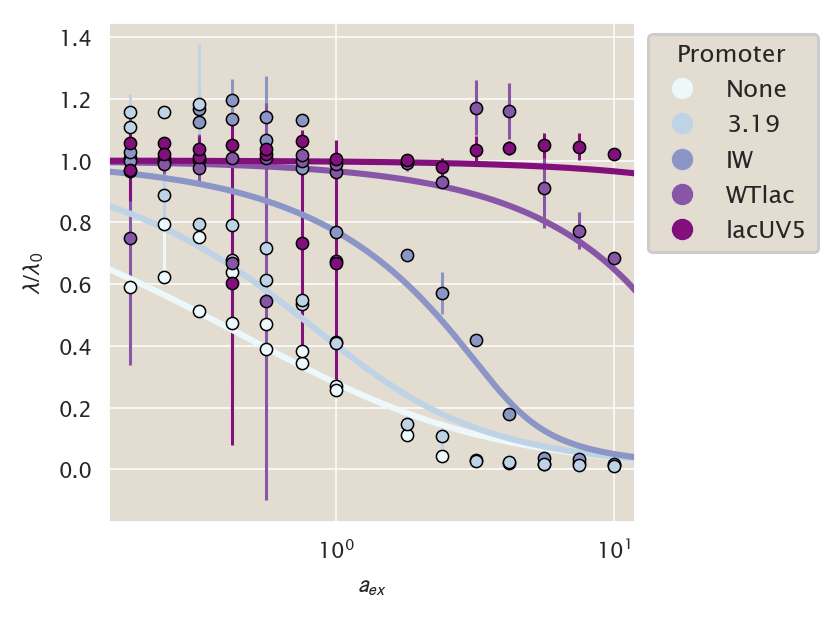

In [11]:
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1,
    figsize=(4,3),
)
ax.set_xlabel(r"$a_{ex}$")
ax.set_ylabel(r"$\lambda/\lambda_0$")
colors = [x for x in reversed(bokeh.palettes.BuPu[6])]

ax = _tetA_lam_roots_plot(lam_o, j, 0, 20, "normalized", ax, colors[0])  
ax = _tetA_lam_roots_plot(lam_o, j, 20, 20, "normalized", ax, colors[1]) 
ax = _tetA_lam_roots_plot(lam_o, j, 100, 20, "normalized", ax, colors[3]) 
ax = _tetA_lam_roots_plot(lam_o, j, 700, 20, "normalized", ax, colors[4]) 
ax = _tetA_lam_roots_plot(lam_o, j, 7000, 20, "normalized", ax, colors[5]) 

promoter_plot = ["MG1655", "3.19", "IW", "WT", ""]#, "WT", "UV5"]
conc_plot = [0, 0., 1]
groups = list(itertools.product(promoter_plot, conc_plot))


prom_colors = {"MG1655": colors[0],  "3.19": colors[1], "IW": colors[3], "WT": colors[4], "UV5": colors[5]}


#p.add_layout(bokeh.models.Legend(), 'right')

for prom in ['MG1655', "IW", "3.19", "WT", "UV5"]:#df_means['promoter'].unique():
    data = df_means[
        df_means['promoter'] == prom].sort_values(by="tc")


    x = data['tc'].values[:]
    y = data['λ/λ0_mean'].values[:]
    y_err = data['λ/λ0_std'].values[:]
    print(x)
    # Plot growth curve
    ax.errorbar(
        x,
        y,
        yerr=y_err,
        linewidth=1.5,
        markersize=4,
        markeredgewidth=0.5,
        markeredgecolor="black",
        #legend_label=f"{group[0]} - {group[1]}",
        #linestyle=promoter_styles[group[0]],
        color=prom_colors[prom],
        label=f"{prom}",
        fmt='s',
        elinewidth=1,
        marker='o'


    )

legend_elements = [Line2D([0], [0], color='gray', lw=0, label='Promoter'),
                   Line2D([0], [0], color=colors[0], marker='o', lw=0, label='None'),
                   Line2D([0], [0], color=colors[1], marker='o', lw=0, label='3.19'),
                   Line2D([0], [0], color=colors[3], marker='o', lw=0, label='IW'),
                   Line2D([0], [0], color=colors[4], marker='o', lw=0, label='WTlac'),
                   Line2D([0], [0], color=colors[5], marker='o', lw=0, label='lacUV5'),
                   
                   
                  ]

leg = ax.legend(
    handles=legend_elements, 
    ncol=1, 
    bbox_to_anchor=(1, 1), 
    loc='upper left'
)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
ax.set_xlim([0.15, 12])
ax.set_xscale('log')

plt.tight_layout()
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

plt.savefig("resistance_model.svg")

In [7]:
df_means = pd.read_csv("../analysis/relative_growthrates.csv", index_col=0)
df_means

,promoter,pos_selection,date,λ/λ0_mean,λ/λ0_std,lag_mean,lag_std,tc
0,3.19,0.18_µg/ml_tc,20210712,1.155575,0.036109,294.077114,2.634872,0.18
1,3.19,0.18_µg/ml_tc,20210713,1.107307,0.106621,325.943298,3.576585,0.18
2,3.19,0.24_µg/ml_tc,20210712,1.158568,0.005082,302.189615,16.789996,0.24
3,3.19,0.24_µg/ml_tc,20210713,0.888692,0.076589,341.856998,6.194981,0.24
4,3.19,0.32_µg/ml_tc,20210712,1.182982,0.193253,350.491945,16.135357,0.32
...,...,...,...,...,...,...,...,...
115,WT,2.4_µg/ml_tc,20210714,0.929475,0.017178,265.080329,8.998014,2.40
116,WT,3.2_µg/ml_tc,20210714,1.171044,0.088305,300.377504,1.567795,3.20
117,WT,4.2_µg/ml_tc,20210714,1.160714,0.091616,294.205308,14.372700,4.20
118,WT,5.6_µg/ml_tc,20210714,0.911642,0.128754,156.034573,186.489382,5.60


[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]
[ 0.    0.    0.    0.18  0.18  0.24  0.24  0.32  0.32  0.42  0.42  0.56
  0.56  0.75  0.75  1.    1.    1.8   2.4   3.2   4.2   5.6   7.5  10.  ]


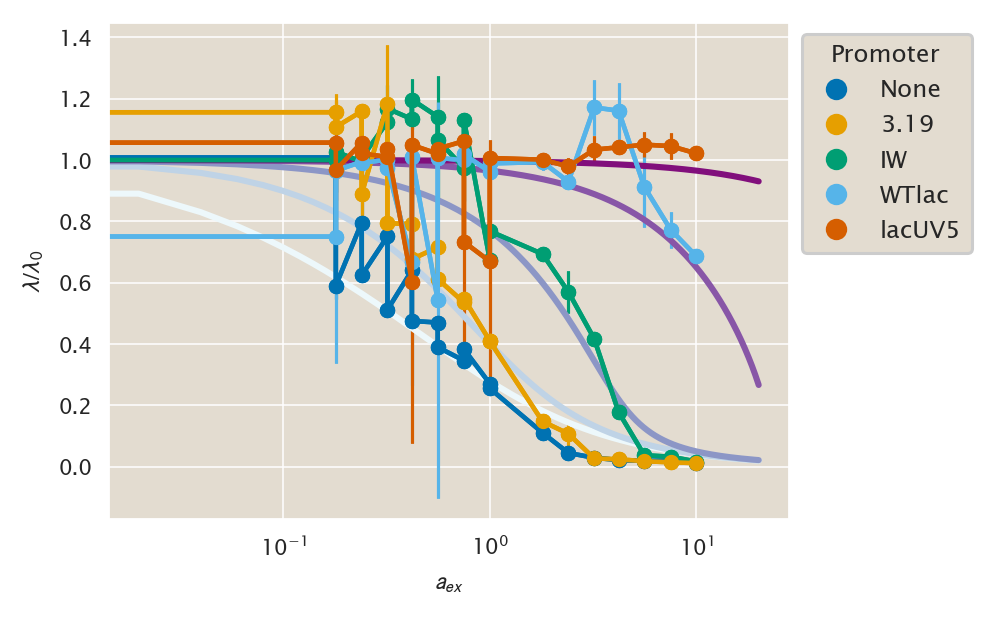

<Figure size 385x275 with 0 Axes>

In [10]:
promoter_plot = ["MG1655", "3.19", "IW", "WT", ""]#, "WT", "UV5"]
conc_plot = [0, 0., 1]
groups = list(itertools.product(promoter_plot, conc_plot))

colors = bokeh.palettes.Colorblind[6]
prom_colors = {"MG1655": colors[0],  "3.19": colors[1], "IW": colors[3], "WT": colors[4], "UV5": colors[5]}


#p.add_layout(bokeh.models.Legend(), 'right')
for prom in ['MG1655', "IW", "3.19", "WT", "UV5"]:#df_means['promoter'].unique():
    data = df_means[
        df_means['promoter'] == prom].sort_values(by="tc")


    x = data['tc'].values[:]
    y = data['λ/λ0_mean'].values[:]
    y_err = data['λ/λ0_std'].values[:]
    print(x)
    # Plot growth curve
    ax.errorbar(
        x,
        y,
        yerr=y_err,
        linewidth=1.5,
        markersize=4,
        #legend_label=f"{group[0]} - {group[1]}",
        #linestyle=promoter_styles[group[0]],
        color=prom_colors[prom],
        label=f"{prom}",
        #fmt='s',
        elinewidth=1,
        marker='o'


    )
    
legend_elements = [Line2D([0], [0], color='gray', lw=0, label='Promoter'),
                   Line2D([0], [0], color=colors[0], marker='o', lw=0, label='None'),
                   Line2D([0], [0], color=colors[1], marker='o', lw=0, label='3.19'),
                   Line2D([0], [0], color=colors[3], marker='o', lw=0, label='IW'),
                   Line2D([0], [0], color=colors[4], marker='o', lw=0, label='WTlac'),
                   Line2D([0], [0], color=colors[5], marker='o', lw=0, label='lacUV5'),
                   
                   
                  ]


leg = ax.legend(
    handles=legend_elements, 
    ncol=1, 
    bbox_to_anchor=(1, 1), 
    loc='upper left'
)
for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
#ax.set_xlim([0.18, 10])
ax.set_xscale('log')

plt.tight_layout()
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})
#plt.savefig("growth_rates3.svg")
fig